In [1]:
import os
import sys
import pickle
import numpy as np
import pandas as pd
from PIL import Image, ImageFilter
from tqdm import tqdm_notebook
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, mean_squared_error, log_loss, confusion_matrix
import matplotlib.pyplot as plt
import cv2 as cv
from PIL import Image, ImageFilter, ImageEnhance

np.random.seed(100)
# LEVEL = 'level_1'

In [2]:
class SigmoidNeuron:
  
  def __init__(self):
    self.w = None
    self.b = None
    
  def perceptron(self, x):
    return np.dot(x, self.w.T) + self.b
  
  def sigmoid(self, x):
    return 1.0/(1.0 + np.exp(-x))
  
  def grad_w_mse(self, x, y):
    y_pred = self.sigmoid(self.perceptron(x))
    return (y_pred - y) * y_pred * (1 - y_pred) * x
  
  def grad_b_mse(self, x, y):
    y_pred = self.sigmoid(self.perceptron(x))
    return (y_pred - y) * y_pred * (1 - y_pred)
  
  def grad_w_ce(self, x, y):
    y_pred = self.sigmoid(self.perceptron(x))
    if y == 0:
      return y_pred * x
    elif y == 1:
      return -1 * (1 - y_pred) * x
    else:
      raise ValueError("y should be 0 or 1")
    
  def grad_b_ce(self, x, y):
    y_pred = self.sigmoid(self.perceptron(x))
    if y == 0:
      return y_pred 
    elif y == 1:
      return -1 * (1 - y_pred)
    else:
      raise ValueError("y should be 0 or 1")
  
  def fit(self, X, Y, epochs=1, learning_rate=1, initialise=True, loss_fn="mse", display_loss=False):
    
    # initialise w, b
    if initialise:
      self.w = np.random.randn(1, X.shape[1])
      self.b = 0
      
    if display_loss:
      loss = {}
    
    for i in tqdm_notebook(range(epochs), total=epochs, unit="epoch"):
      dw = 0
      db = 0
      for x, y in zip(X, Y):
        if loss_fn == "mse":
          dw += self.grad_w_mse(x, y)
          db += self.grad_b_mse(x, y) 
        elif loss_fn == "ce":
          dw += self.grad_w_ce(x, y)
          db += self.grad_b_ce(x, y)
      self.w -= learning_rate * dw
      self.b -= learning_rate * db
      
      if display_loss:
        Y_pred = self.sigmoid(self.perceptron(X))
        if loss_fn == "mse":
          loss[i] = mean_squared_error(Y, Y_pred)
        elif loss_fn == "ce":
          loss[i] = log_loss(Y, Y_pred)
    
    if display_loss:
      plt.plot(loss.values())
      plt.xlabel('Epochs')
      if loss_fn == "mse":
        plt.ylabel('Mean Squared Error')
      elif loss_fn == "ce":
        plt.ylabel('Log Loss')
      plt.show()
      
  def predict(self, X):
    Y_pred = []
    for x in X:
      y_pred = self.sigmoid(self.perceptron(x))
      Y_pred.append(y_pred)
    return np.array(Y_pred)

In [3]:
def increase_brightness(img,value):
    hsv = cv.cvtColor(img, cv.COLOR_BGR2HSV)
    h, s, v = cv.split(hsv)

    lim = 255 - value
    v[v > lim] = 255
    v[v <= lim] += value

    final_hsv = cv.merge((h, s, v))
    image = cv.cvtColor(final_hsv, cv.COLOR_HSV2BGR)
    return image

In [4]:
def read_all(folder_path, key_prefix=""):
    '''
    It returns a dictionary with 'file names' as keys and 'flattened image arrays' as values.
    '''
    print("Reading:")
    images = {}
    files = os.listdir(folder_path)
    for i, file_name in tqdm_notebook(enumerate(files), total=len(files)):
        file_path = os.path.join(folder_path, file_name)
        image_index = key_prefix + file_name[:-4]
        image = cv.imread(file_path)
        image = increase_brightness(image,10)                    # Increase brightness with 10 pixels
        image = cv.cvtColor(image,cv.COLOR_BGR2GRAY)             # Convert image to Gray Scale
        kernel = np.ones((2,2), np.uint8)                        # Define a kernel of size 2X2, small kernel because image is also very small i.e. 64X64 only
        ret,image = cv.threshold(image,25,255,cv.THRESH_BINARY)  # Binary threshold to convert image into Black and White. All pixels having value above or equal to 25 will be converted into White (255) and lower than 25 will be converted to Black (0))
        image = cv.bitwise_not(image)                            # Invert the image. Black pixels to white and white pixels to black
        image = cv.morphologyEx(image, cv.MORPH_OPEN, kernel)    # Reducing Noise in an image
        image = cv.morphologyEx(image, cv.MORPH_CLOSE, kernel)   # Reducing Noise inside letter
        image = cv.bitwise_not(image)                            # Invert again
        image = cv.medianBlur(image,3)                           # Increase the thickness of letter so that it's more prominent and easily recogonizable
        images[image_index] = image.flatten()   
    return images

In [5]:
languages = ['ta', 'hi', 'en']

images_train = read_all(r"C:\Users\Venkatraman.R\Documents\PERSONAL_PROJECTS\PADHAI_COURSE\CONTEST_2\LEVEL_4\padhai-module1-level4a\level_4a_train\level_4a\background", key_prefix='bgr_') # change the path
for language in languages:
  images_train.update(read_all(r"C:\Users\Venkatraman.R\Documents\PERSONAL_PROJECTS\PADHAI_COURSE\CONTEST_2\LEVEL_4\padhai-module1-level4a\level_4a_train\level_4a"+"/"+language, key_prefix=language+"_" ))
print(len(images_train))

images_test = read_all(r"C:\Users\Venkatraman.R\Documents\PERSONAL_PROJECTS\PADHAI_COURSE\CONTEST_2\LEVEL_4\padhai-module1-level4a\level_4a_test\kaggle_level_4a", key_prefix='') # change the path
print(len(images_test))


# languages = ['en','ta', 'hi']

# images_train = read_all("../input/"+LEVEL+"_train/"+LEVEL+"/"+"background", key_prefix='bgr_') 
# for language in languages:
#   images_train.update(read_all("../input/"+LEVEL+"_train/"+LEVEL+"/"+language, key_prefix=language+"_" ))
# print(len(images_train))

# images_test = read_all("../input/"+LEVEL+"_test/kaggle_"+LEVEL, key_prefix='') 
# print(len(images_test))

Reading:



Reading:



Reading:



Reading:



9000
Reading:



3000


In [6]:
list(images_test.keys())[:5]

['0', '1', '10', '100', '1000']

In [7]:
X_train = []
Y_train = []
for key, value in images_train.items():
    X_train.append(value)
    if key[:4] == "bgr_":
        Y_train.append(0)
    else:
        Y_train.append(1)

ID_test = []
X_test = []
for key, value in images_test.items():
  ID_test.append(int(key))
  X_test.append(value)
  
        
X_train = np.array(X_train)
Y_train = np.array(Y_train)
X_test = np.array(X_test)

print(X_train.shape, Y_train.shape)
print(X_test.shape)

(9000, 4096) (9000,)
(3000, 4096)


In [8]:
scaler = StandardScaler()
X_scaled_train = scaler.fit_transform(X_train)
X_scaled_test = scaler.transform(X_test)

C:\Users\Venkatraman.R\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype uint8 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


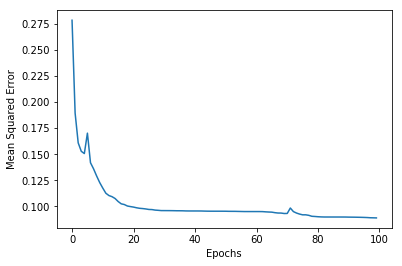

In [9]:
sn_mse = SigmoidNeuron()
sn_mse.fit(X_scaled_train, Y_train, epochs=100, learning_rate=0.015, loss_fn="mse", display_loss=True)

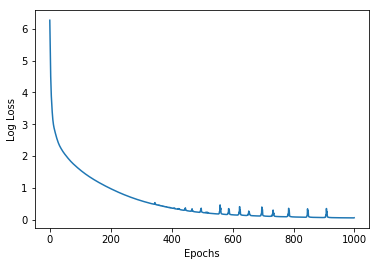

In [10]:
sn_ce = SigmoidNeuron()
sn_ce.fit(X_scaled_train, Y_train, epochs=1000, learning_rate=0.00005, loss_fn="ce", display_loss=True)

In [11]:
def print_accuracy(sn):
  Y_pred_train = sn.predict(X_scaled_train)
  Y_pred_binarised_train = (Y_pred_train >= 0.5).astype("int").ravel()
  accuracy_train = accuracy_score(Y_pred_binarised_train, Y_train)
  print("Train Accuracy : ", accuracy_train)
  print("-"*50)

In [12]:
print_accuracy(sn_mse)
print_accuracy(sn_ce)

Train Accuracy :  0.9108888888888889
--------------------------------------------------
Train Accuracy :  0.9914444444444445
--------------------------------------------------


## Sample Submission

In [14]:
Y_pred_test = sn_ce.predict(X_scaled_test)
Y_pred_binarised_test = (Y_pred_test >= 0.5).astype("int").ravel()

submission = {}
submission['ImageId'] = ID_test
submission['Class'] = Y_pred_binarised_test

submission = pd.DataFrame(submission)
submission = submission[['ImageId', 'Class']]
submission = submission.sort_values(['ImageId'])
submission.to_csv("submisision.csv", index=False)

### CHECKING THE IMAGE 

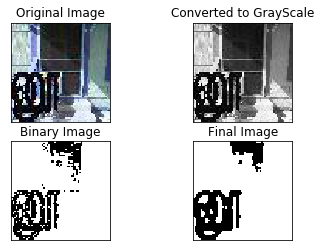

In [17]:
image = cv.imread(r"C:\Users\Venkatraman.R\Documents\PERSONAL_PROJECTS\PADHAI_COURSE\CONTEST_2\LEVEL_4\padhai-module1-level4a\level_4a_test\kaggle_level_4a\3.jpg")

image = increase_brightness(image,10)
imgo = image

image = cv.cvtColor(image,cv.COLOR_BGR2GRAY)
gray_image = image
ret,image = cv.threshold(image,25,255,cv.THRESH_BINARY)
binary_image = image
image = cv.medianBlur(image,3)

titles = ['Original Image','Converted to GrayScale','Binary Image','Final Image']
images = [imgo, gray_image, binary_image, image]
for i in range(0,4):
   plt.subplot(2,2,i+1),plt.imshow(images[i],'gray')
   plt.title(titles[i])
   plt.xticks([]),plt.yticks([])